In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
import math

注: Google Driveとのマウントが必要

In [2]:
filenames = ["221213_MZI_Vg=0.0V.csv", "221213_MZI_Vg=0.5V.csv", "221213_MZI_Vg=1.0V.csv", "221213_MZI_Vg=1.5V.csv", "221213_MZI_Vg=2.0V.csv", "221213_MZI_Vg=2.5V.csv", "221213_MZI_Vg=3.0V.csv"]
voltages = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3])
voltage_labels = ["0.0V", "0.5V", "1.0V", "1.5V", "2.0V", "2.5V", "3.0V"]

FSR = 29.300000000000068


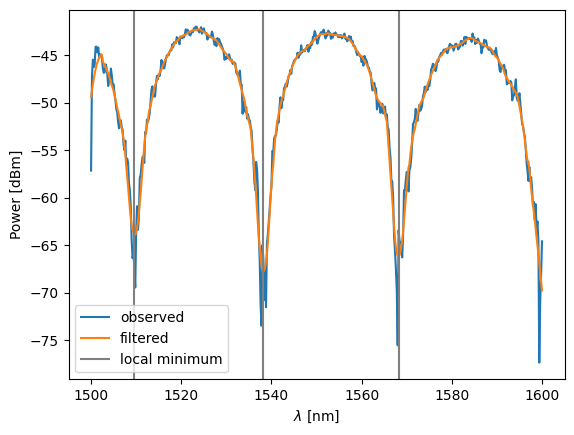

FSR = 29.300000000000068


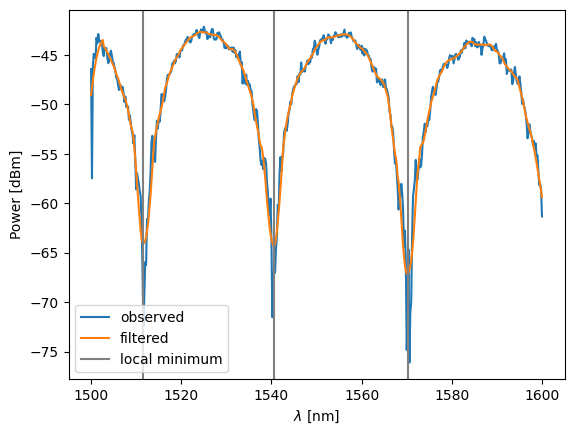

FSR = 29.0


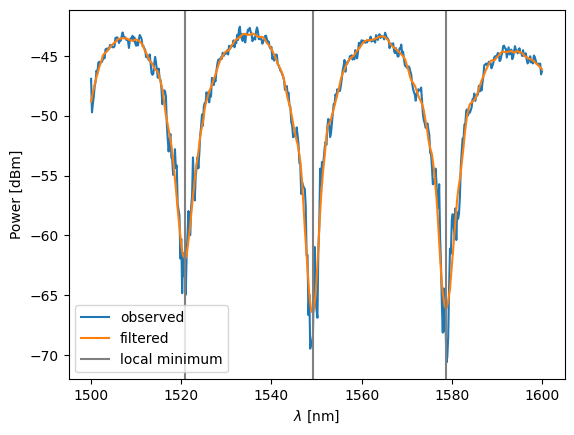

FSR = 27.866666666666713


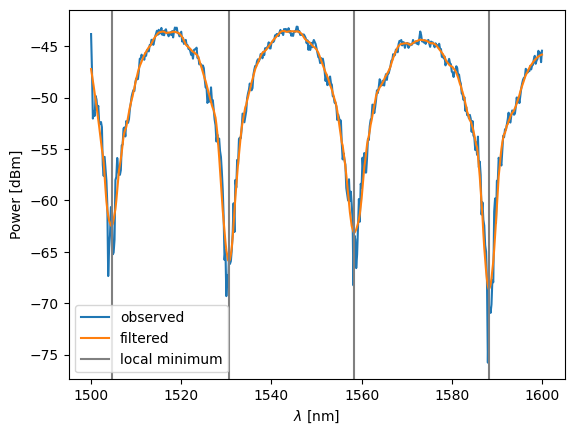

FSR = 27.933333333333394


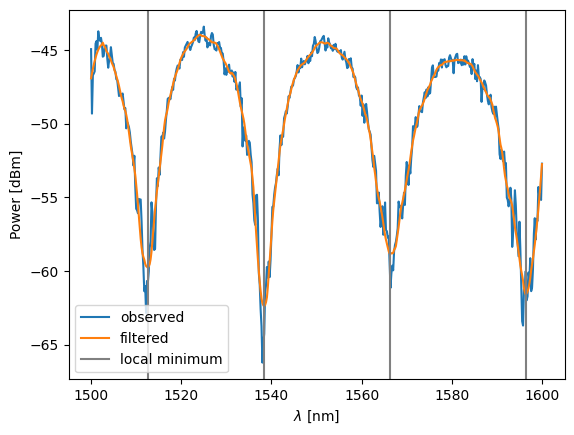

FSR = 27.300000000000068


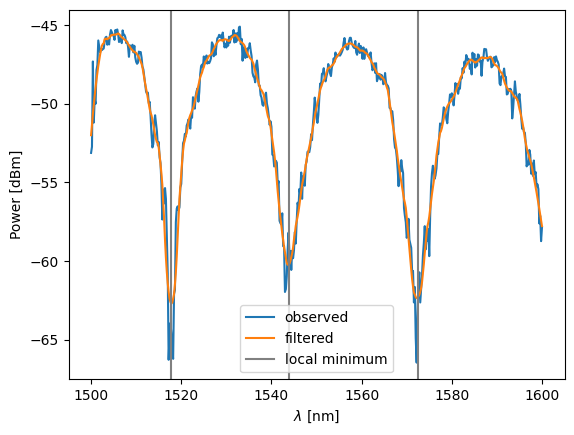

FSR = 27.0


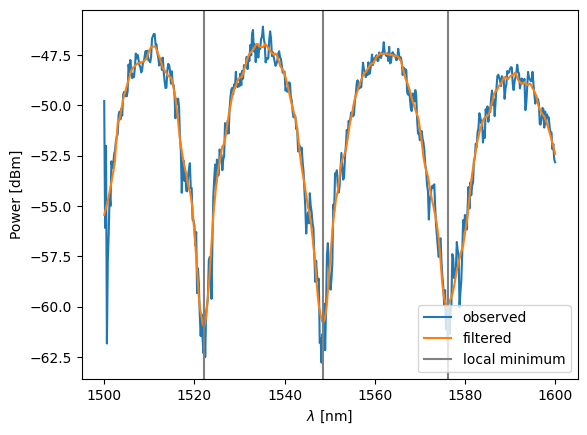

In [7]:
fsrs = []
for index in range(len(filenames)):
    filename = filenames[index]
    voltage_label = voltage_labels[index]
    filepath = "../../dat/day2/" + filename
    dat = pd.read_csv(filepath)
    v_sav = savgol_filter(dat["Raw [dBm]"], 25, 2)
    plt.plot(dat["Wavelength [nm]"], dat["Raw [dBm]"])
    plt.plot(dat["Wavelength [nm]"], v_sav)

    # plt.title(voltage_label)
    plt.xlabel("$\lambda$ [nm]")
    plt.ylabel("Power [dBm]")

    
    # FSRを求める
    lambda_vals = []
    descend_flag = False
    x_vals = dat["Wavelength [nm]"]
    for i in range(len(v_sav) - 1):
        # 極小値におけるlambdaの値をlambda_valsに記録
        if descend_flag and v_sav[i] < v_sav[i + 1] and (len(lambda_vals) == 0 or x_vals[i] > lambda_vals[-1] + 25) and v_sav[i] < -55:
            descend_flag = False
            lambda_vals.append(x_vals[i])
        if v_sav[i] > v_sav[i + 1]:
            descend_flag = True
    # print(lambda_vals)
    for v in lambda_vals:
        plt.axvline(v, color="gray")
    lambda_diffs = np.diff(lambda_vals)
    fsr = np.average(lambda_diffs)
    print(f"FSR = {fsr}")
    fsrs.append(fsr)

    plt.legend(["observed", "filtered", "local minimum"])
    plt.savefig(f"../../plot/day2/{voltage_label}.png")
    plt.show()

fsrs = np.array(fsrs)

In [4]:
local_min_lambdas = [[] for _ in range(len(filenames))]
for index in range(len(filenames)):
    filename = filenames[index]
    voltageLabel = voltage_labels[index]
    filepath = "/content/drive/Shareddrives/18MOSデバイス/2日目/" + filename
    dat = pd.read_csv(filepath)
    v_sav = savgol_filter(dat["Raw [dBm]"], 25, 2)
    plt.plot(dat["Wavelength [nm]"], v_sav)

    # 極小値におけるlambdaの配列を得る
    descend_flag = False
    x_vals = dat["Wavelength [nm]"]
    for i in range(len(v_sav) - 1):
        # 極小値におけるlambdaの値をlocal_min_lambdasに記録
        if descend_flag and v_sav[i] < v_sav[i + 1] and (len(local_min_lambdas[index]) == 0 or x_vals[i] > local_min_lambdas[index][-1] + 25) and v_sav[i] < -55:
            descend_flag = False
            local_min_lambdas[index].append(x_vals[i])
        if v_sav[i] > v_sav[i + 1]:
            descend_flag = True
    
    # 今注目するのはlambda > 1535の部分なので、filter
    local_min_lambdas[index] = list(filter(lambda x: x > 1535, local_min_lambdas[index]))


# VgとΔλの関係を求める
# Vgを大きくしていくと、位相のズレは正の方向にのみ起こるという過程を置き、
# lambdasから適切に要素を取り出し
delta_lambdas = []
for index in range(len(filenames)):
    prev_value = delta_lambdas[-1] if len(delta_lambdas) != 0 else 0
    # 前回の値より大きいλのうち、最小のものを求める
    filtered_list = list(filter(lambda x: prev_value < x, local_min_lambdas[index]))
    if len(filtered_list) == 0:
        raise ValueError("Could not calculate delta lambda.")
    val = filtered_list[0]
    delta_lambdas.append(val)

delta_lambdas = np.array(delta_lambdas)
print(delta_lambdas)
# for d in delta_lambdas:
#     plt.axvline(x=d)

initial_val = delta_lambdas[0]
delta_lambdas = delta_lambdas - initial_val

plt.legend(voltage_labels)
plt.xlim([1535, 1600])
plt.xlabel("$\lambda$ [nm]")
plt.ylabel("Power [dBm]")
plt.show()

# VgとΔλの関係をプロット
plt.scatter(voltages, delta_lambdas)
plt.xlabel("Vg [V]")
plt.ylabel("$\Delta \lambda$ [$\pi$]")
plt.show()

# VgとΔθの関係をプロット
delta_thetas = 2 * delta_lambdas / fsrs
plt.scatter(voltages, delta_thetas)

a, b = np.polyfit(voltages[2:], delta_thetas[2:], 1) #fitting
plt.plot(voltages, a * voltages + b, color="orange")
plt.legend(["regression line", "observed"])

plt.xlabel("Vg [V]")
plt.ylabel("$\Delta \Theta$ [$\pi$]")
plt.show()

# V_piを求める
# V_piとは、回帰直線がpiになる点
# 今、グラフはpiを単位にプロットしているので、1になるVを探す
# a * V_pi + b = 1の点を求めればいいから
# V_pi = (1 - b) / a
v_pi = (1 - b) / a
print(f"V_pi = {v_pi}")

# 変調効率を求める(単位: V * cm)
# 変調効率 = V_pi * L
mod_eff = v_pi * 0.1
print(f"変調効率: {mod_eff}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/18MOSデバイス/2日目/221213_MZI_Vg=0.0V.csv'